<a href="https://colab.research.google.com/github/zahraniayudyaa/TUGAS-ML/blob/main/ch_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Memahami Gambaran Besar (Look at the Big Picture)**
---
Chapter ini akan memandu kita melalui proyek ML lengkap untuk memprediksi harga rumah di California. Langkah pertama adalah memahami business objective: perusahaan real estate ingin model yang dapat memprediksi median harga rumah di setiap distrik berdasarkan data sensus. Model ini akan menjadi input untuk sistem lain yang menentukan investasi.

**Problem framing:**
* Supervised learning karena kita memiliki labeled examples (harga rumah)
* Regression task karena kita memprediksi nilai kontinu
* Multiple regression karena menggunakan banyak fitur
* Univariate regression karena hanya satu output
* Batch learning karena data kecil dan tidak perlu update real-time

**Performance measure:** RMSE (Root Mean Square Error) dipilih karena memberikan bobot lebih untuk error besar.

### **Implementasi Setup Awal:**

In [14]:
# Setup environment dan import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import urllib.request
from pathlib import Path

# Setup visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Print versi library untuk reproducibility
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

numpy: 2.0.2
pandas: 2.2.2


# **2. Mendapatkan Data (Get the Data)**
---
Kita menggunakan California Housing Prices dataset dari StatLib repository. Dataset ini berisi data sensus California tahun 1990 dengan 20,640 instance dan 10 atribut. Langkah pertama adalah mendownload data dan memuatnya ke dalam pandas DataFrame.

### **Implementasi Fetch Data:**

In [15]:
# Fungsi untuk download data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = Path("datasets/housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Download dan extract dataset housing"""
    housing_path.mkdir(parents=True, exist_ok=True)
    tgz_path = housing_path / "housing.tgz"
    urllib.request.urlretrieve(housing_url, tgz_path)

    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path)

    print(f"Dataset downloaded to {housing_path}")

def load_housing_data(housing_path=HOUSING_PATH):
    """Load data ke pandas DataFrame"""
    csv_path = housing_path / "housing.csv"
    return pd.read_csv(csv_path)

# Download dan load data
fetch_housing_data()
housing = load_housing_data()

print("Dataset shape:", housing.shape)
print("\nFirst 5 rows:")
print(housing.head())

Dataset downloaded to datasets/housing
Dataset shape: (20640, 10)

First 5 rows:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR 

/tmp/ipython-input-626040345.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


# **3. Analisis Data Eksplorasi (EDA)**
---
EDA membantu kita memahami karakteristik data:
* **Data overview:** tipe data, missing values, distribusi
* **Visualisasi geografis:** pola spasial harga rumah
* **Analisis korelasi:** hubungan antar variabel
* **Feature engineering:** membuat fitur baru dari kombinasi fitur existing

### **Implementasi EDA:**

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


Descriptive Statistics:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763

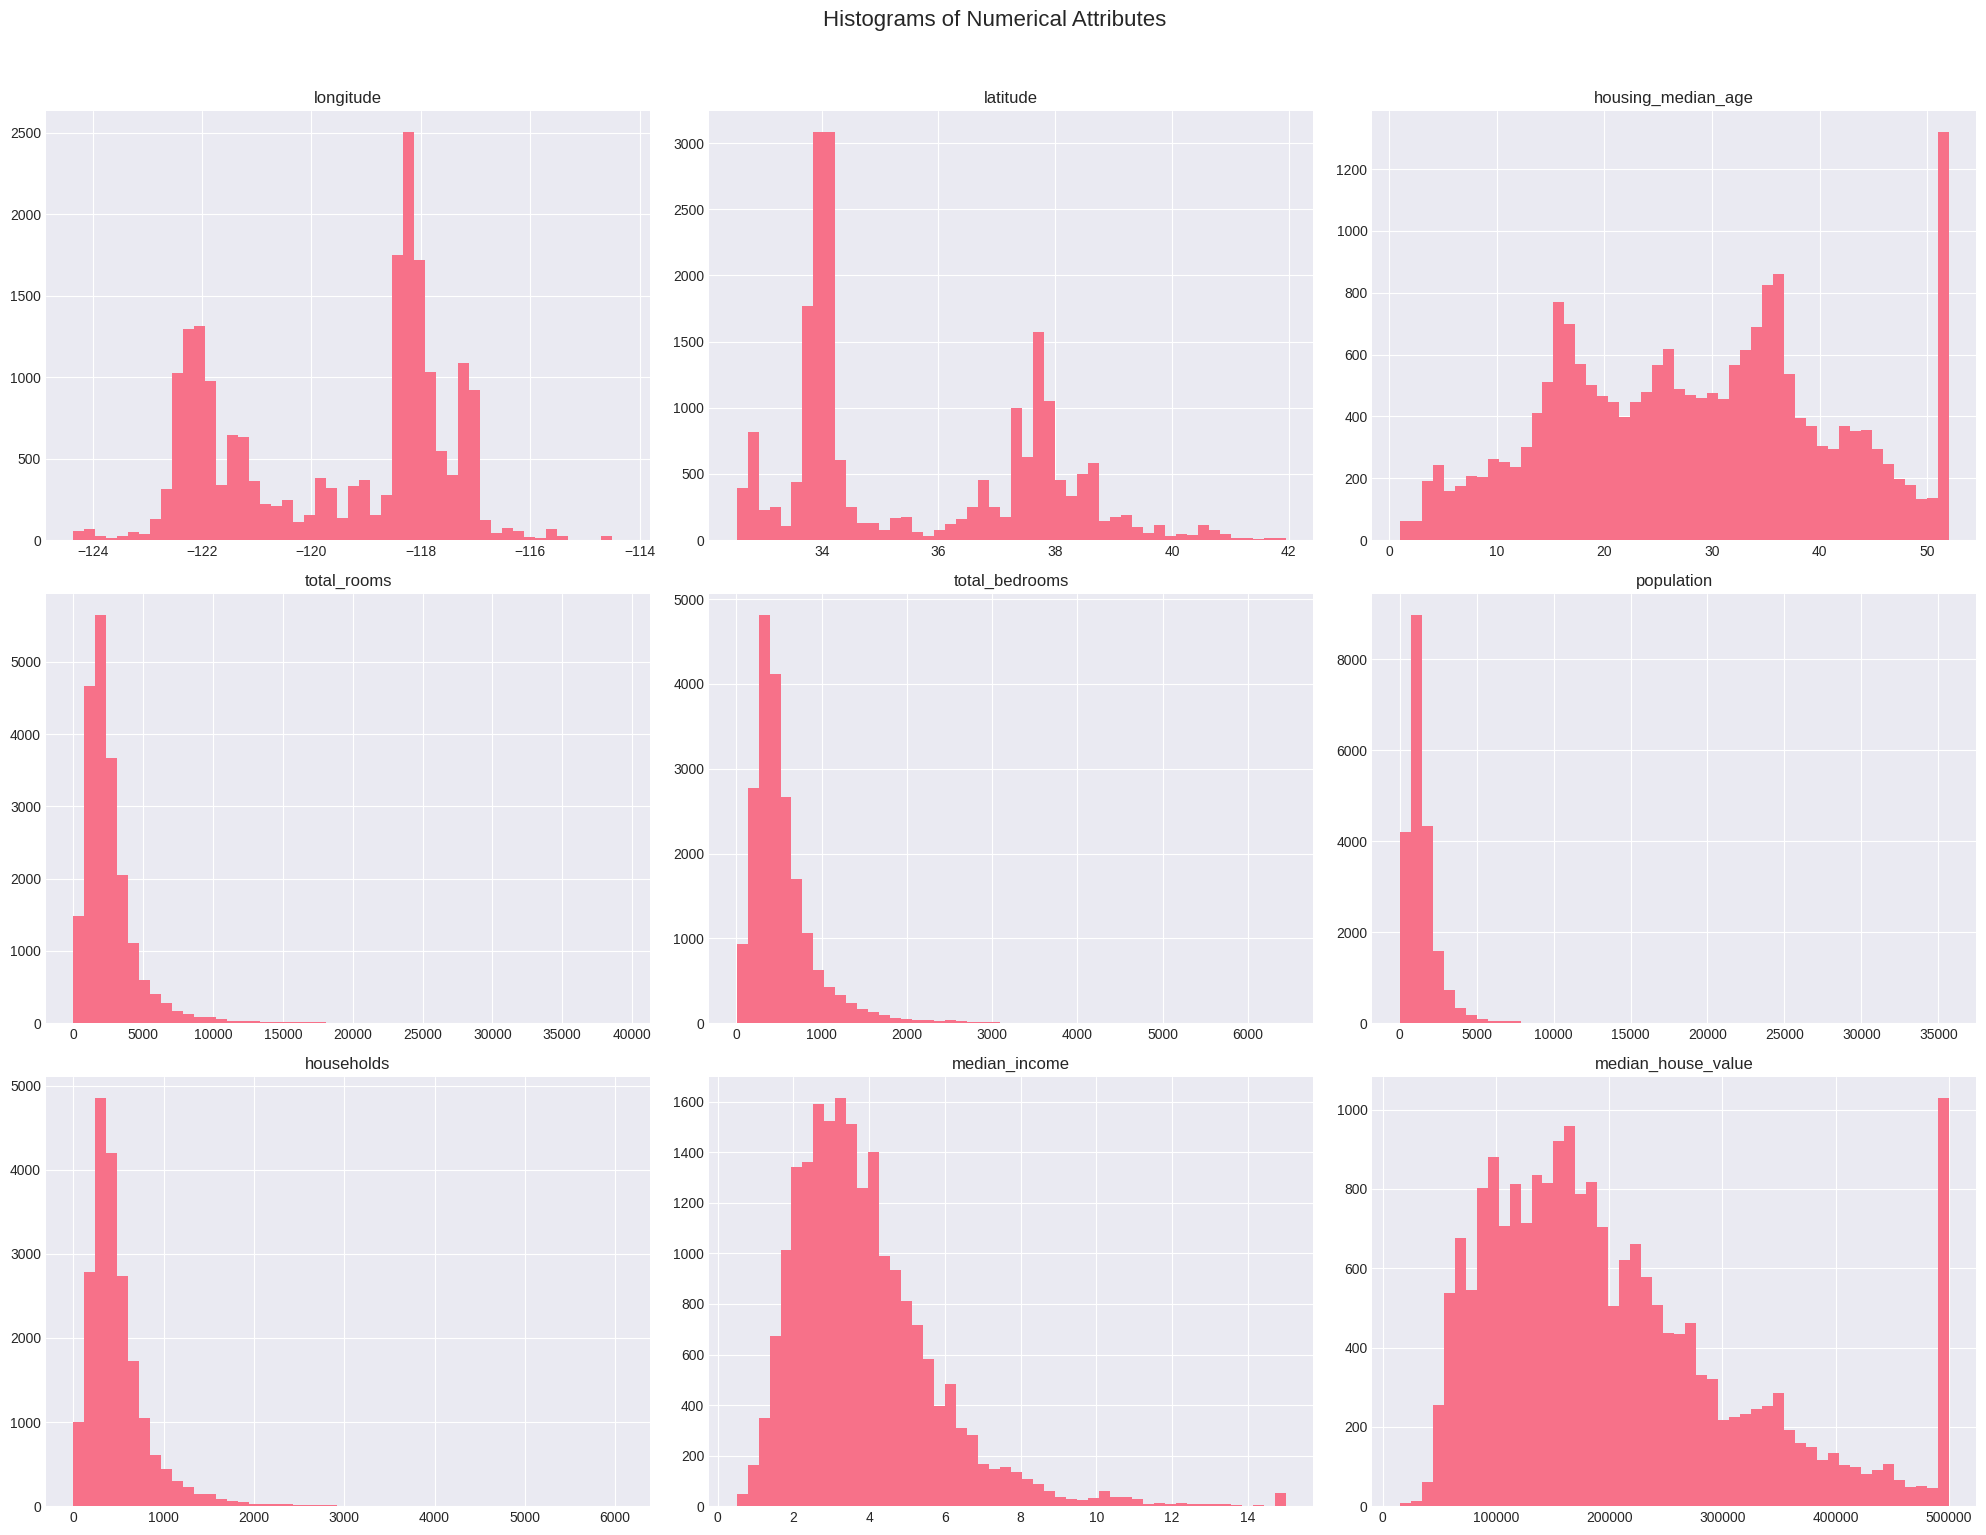

In [16]:
# 3.1 Info dataset
print("Dataset Info:")
print(housing.info())
print("\n" + "="*50 + "\n")

# 3.2 Statistik deskriptif
print("Descriptive Statistics:")
print(housing.describe())
print("\n" + "="*50 + "\n")

# 3.3 Distribusi kategori untuk ocean_proximity
print("Ocean Proximity Distribution:")
print(housing["ocean_proximity"].value_counts())
print("\n" + "="*50 + "\n")

# 3.4 Visualisasi histogram semua atribut numerik
housing.hist(bins=50, figsize=(20, 15))
plt.suptitle("Histograms of Numerical Attributes", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

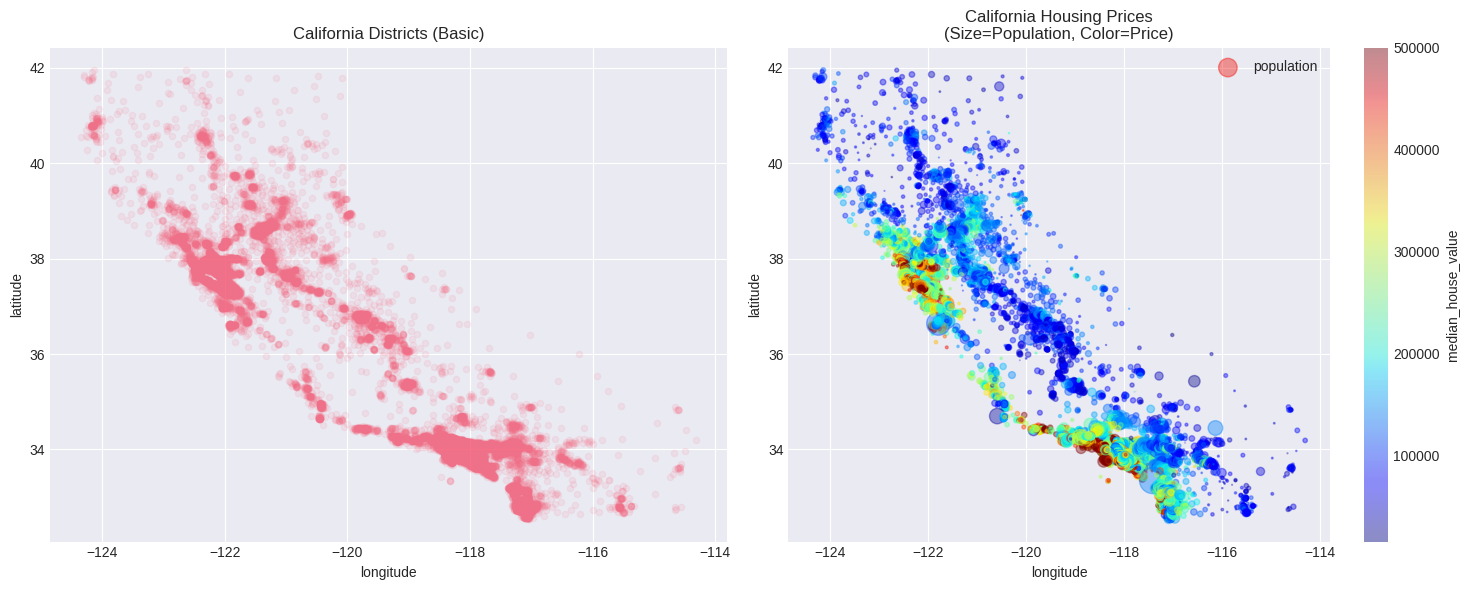

In [17]:
# 3.5 Visualisasi geografis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot dasar
housing.plot(kind="scatter", x="longitude", y="latitude",
            alpha=0.1, ax=axes[0])
axes[0].set_title("California Districts (Basic)")

# Scatter plot dengan informasi harga dan populasi
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"),
            colorbar=True, ax=axes[1])
axes[1].set_title("California Housing Prices\n(Size=Population, Color=Price)")
axes[1].legend()

plt.tight_layout()
plt.show()

Correlation with median_house_value:
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64




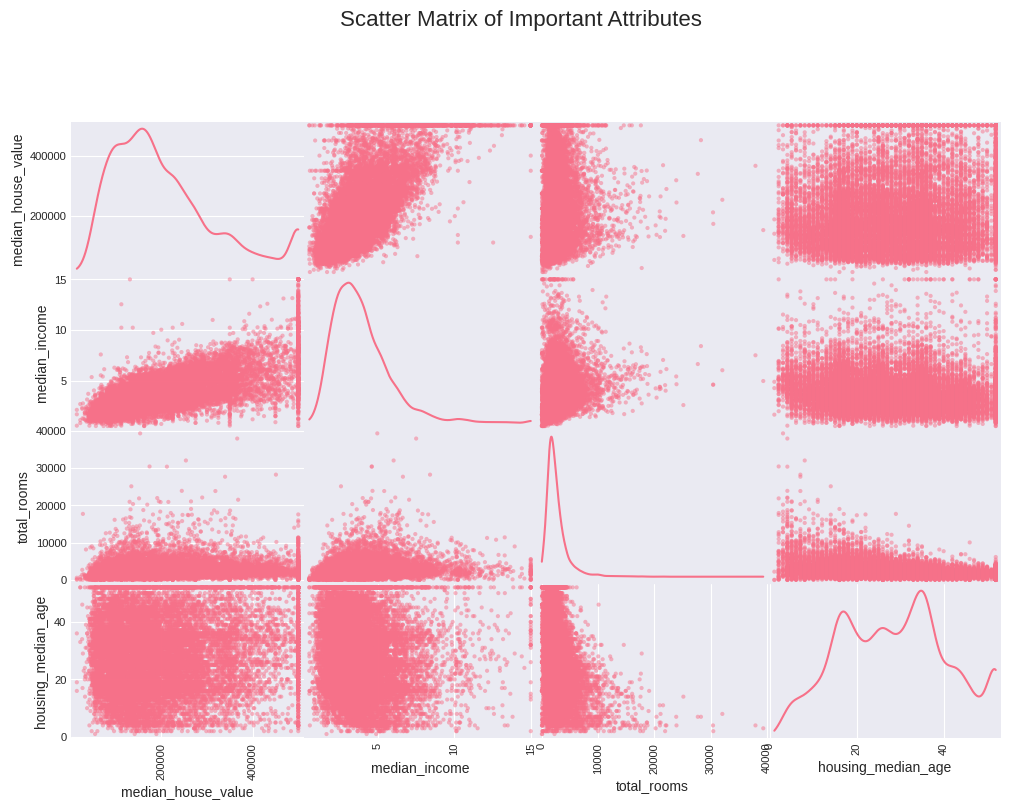

<Figure size 1000x600 with 0 Axes>

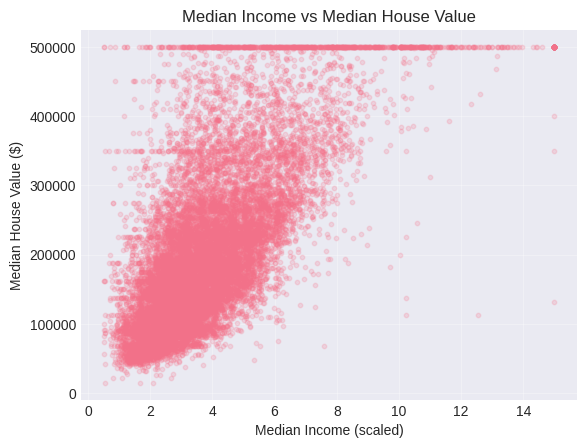

In [18]:
# 3.6 Analisis korelasi
housing_for_eda = strat_train_set.copy()
housing_numeric_for_corr = housing_for_eda.drop("ocean_proximity", axis=1)
corr_matrix = housing_numeric_for_corr.corr()
print("Correlation with median_house_value:")
print(corr_matrix["median_house_value"].sort_values(ascending=False))
print("\n" + "="*50 + "\n")

# 3.7 Scatter matrix untuk atribut penting
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_for_eda[attributes], figsize=(12, 8), diagonal='kde')
plt.suptitle("Scatter Matrix of Important Attributes", fontsize=16, y=1.02)
plt.show()

# 3.8 Zoom in correlation median_income vs median_house_value
plt.figure(figsize=(10, 6))
housing_for_eda.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.2, s=10)
plt.title("Median Income vs Median House Value")
plt.xlabel("Median Income (scaled)")
plt.ylabel("Median House Value ($)")
plt.grid(True, alpha=0.3)
plt.show()

# **4. Persiapan Data (Data Preparation)**
Data preparation adalah langkah kritis:
* **Split data:** training set vs test set (stratified sampling berdasarkan income)
* **Data cleaning:** handle missing values dengan imputation
* **Feature engineering:** buat fitur baru yang lebih informatif
* **Categorical encoding:** one-hot encoding untuk ocean_proximity
* **Feature scaling:** standardization untuk atribut numerik
* **Pipeline:** buat pipeline untuk otomatisasi preprocessing

### **Implementasi Data Preparation:**

In [19]:
# 4.1 Stratified train-test split berdasarkan income category
# Buat income category
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

# Stratified split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Hapus income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(f"Training set size: {len(strat_train_set)}")
print(f"Test set size: {len(strat_test_set)}")
print(f"Train/Test ratio: {len(strat_train_set)/len(housing):.1%}/{len(strat_test_set)/len(housing):.1%}")

# 4.2 Pisahkan features dan labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Training set size: 16512
Test set size: 4128
Train/Test ratio: 80.0%/20.0%


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

# 4.3 Custom Transformer untuk feature engineering
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """Transformer untuk membuat fitur kombinasi baru"""
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, 3] / X[:, 6]  # total_rooms / households
        population_per_household = X[:, 5] / X[:, 6]  # population / households

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, 4] / X[:, 3]  # total_bedrooms / total_rooms
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [21]:
# 4.4 Pipeline lengkap untuk preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Pipeline untuk atribut numerik
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Daftar atribut
num_attribs = list(housing.select_dtypes(include=[np.number]).columns)
cat_attribs = ["ocean_proximity"]

# Full pipeline dengan ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Transform data
housing_prepared = full_pipeline.fit_transform(housing)

print(f"Original features: {len(housing.columns)}")
print(f"Features after preprocessing: {housing_prepared.shape[1]}")
print(f"Sample of transformed data (first row):")
print(housing_prepared[0])

Original features: 9
Features after preprocessing: 16
Sample of transformed data (first row):
[-0.94135046  1.34743822  0.02756357  0.58477745  0.64037127  0.73260236
  0.55628602 -0.8936472   0.01739526  0.00622264 -0.12112176  0.
  1.          0.          0.          0.        ]


# **5. Seleksi dan Training Model**
---
Beberapa model yang akan dicoba:
* **Linear Regression:** baseline model sederhana
* **Decision Tree:** model kompleks yang prone to overfitting
* **Random Forest:** ensemble method yang lebih robust
* **SVM Regressor:** model untuk comparison

Evaluasi menggunakan cross-validation untuk estimasi yang lebih reliable.

### **Implementasi Model Training:**

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# 5.1 Linear Regression (baseline)
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Evaluasi dengan cross-validation
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print("Linear Regression Performance:")
print(f"  RMSE Scores: {lin_rmse_scores}")
print(f"  Mean RMSE: {lin_rmse_scores.mean():.2f}")
print(f"  Std RMSE: {lin_rmse_scores.std():.2f}")

Linear Regression Performance:
  RMSE Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
  Mean RMSE: 69104.08
  Std RMSE: 2880.33


In [23]:
from sklearn.tree import DecisionTreeRegressor

# 5.2 Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

print("\nDecision Tree Performance:")
print(f"  Mean RMSE: {tree_rmse_scores.mean():.2f}")
print(f"  Std RMSE: {tree_rmse_scores.std():.2f}")

# Perbandingan dengan Linear Regression
print(f"\nComparison (lower is better):")
print(f"  Linear Regression: {lin_rmse_scores.mean():.2f}")
print(f"  Decision Tree:     {tree_rmse_scores.mean():.2f}")
print(f"  Difference:        {tree_rmse_scores.mean() - lin_rmse_scores.mean():.2f}")


Decision Tree Performance:
  Mean RMSE: 71629.89
  Std RMSE: 2914.04

Comparison (lower is better):
  Linear Regression: 69104.08
  Decision Tree:     71629.89
  Difference:        2525.81


In [13]:
from sklearn.ensemble import RandomForestRegressor

# 5.3 Random Forest Regressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("\nRandom Forest Performance:")
print(f"  Mean RMSE: {forest_rmse_scores.mean():.2f}")
print(f"  Std RMSE: {forest_rmse_scores.std():.2f}")

print(f"\nModel Comparison Summary:")
models = {
    "Linear Regression": lin_rmse_scores.mean(),
    "Decision Tree": tree_rmse_scores.mean(),
    "Random Forest": forest_rmse_scores.mean()
}
for model_name, score in sorted(models.items(), key=lambda x: x[1]):
    print(f"  {model_name:20} RMSE: {score:10.2f}")


Random Forest Performance:
  Mean RMSE: 50435.58
  Std RMSE: 2203.34

Model Comparison Summary:
  Random Forest        RMSE:   50435.58
  Linear Regression    RMSE:   69104.08
  Decision Tree        RMSE:   71629.89


# **6. Fine-tuning Model**
---
Fine-tuning meliputi:
* **Grid Search:** exhaustive search untuk kombinasi hyperparameter terbaik
* **Randomized Search:** lebih efisien untuk search space besar
* **Feature Importance:** analisis kontribusi setiap fitur
* **Ensemble Methods:** kombinasi model untuk performa lebih baik

### **Implementasi Fine-tuning:**

In [24]:
from sklearn.model_selection import GridSearchCV

# 6.1 Grid Search untuk Random Forest
param_grid = [
    {'n_estimators': [30, 100, 300], 'max_features': [6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [30, 100], 'max_features': [6, 8]},
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True, n_jobs=-1)

grid_search.fit(housing_prepared, housing_labels)

print("Grid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.2f}")

# Tampilkan semua hasil
cv_results = grid_search.cv_results_
print("\nAll combinations tested:")
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"  RMSE: {np.sqrt(-mean_score):.2f} | Params: {params}")

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Grid Search Results:
Best parameters: {'bootstrap': False, 'max_features': 6, 'n_estimators': 100}
Best RMSE: 48672.09

All combinations tested:
  RMSE: 49969.80 | Params: {'max_features': 6, 'n_estimators': 30}
  RMSE: 49317.94 | Params: {'max_features': 6, 'n_estimators': 100}
  RMSE: 49133.27 | Params: {'max_features': 6, 'n_estimators': 300}
  RMSE: 49898.99 | Params: {'max_features': 8, 'n_estimators': 30}
  RMSE: 49339.81 | Params: {'max_features': 8, 'n_estimators': 100}
  RMSE: 49152.59 | Params: {'max_features': 8, 'n_estimators': 300}
  RMSE: 50152.18 | Params: {'max_features': 10, 'n_estimators': 30}
  RMSE: 49620.06 | Params: {'max_features': 10, 'n_estimators': 100}
  RMSE: 49435.98 | Params: {'max_features': 10, 'n_estimators': 300}
  RMSE: 49427.88 | Params: {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
  RMSE: 48672.09 | Params: {'bootstrap': False, 'max_features': 6, 'n_estimators': 100}
  RMSE: 49445.44 | Params: {'bootstrap': False, 'max_features': 8, '


Top 10 Feature Importances:
  median_income             : 0.3193
  INLAND                    : 0.1518
  pop_per_hhold             : 0.1059
  bedrooms_per_room         : 0.0880
  longitude                 : 0.0821
  latitude                  : 0.0745
  rooms_per_hhold           : 0.0549
  housing_median_age        : 0.0415
  population                : 0.0168
  total_rooms               : 0.0166


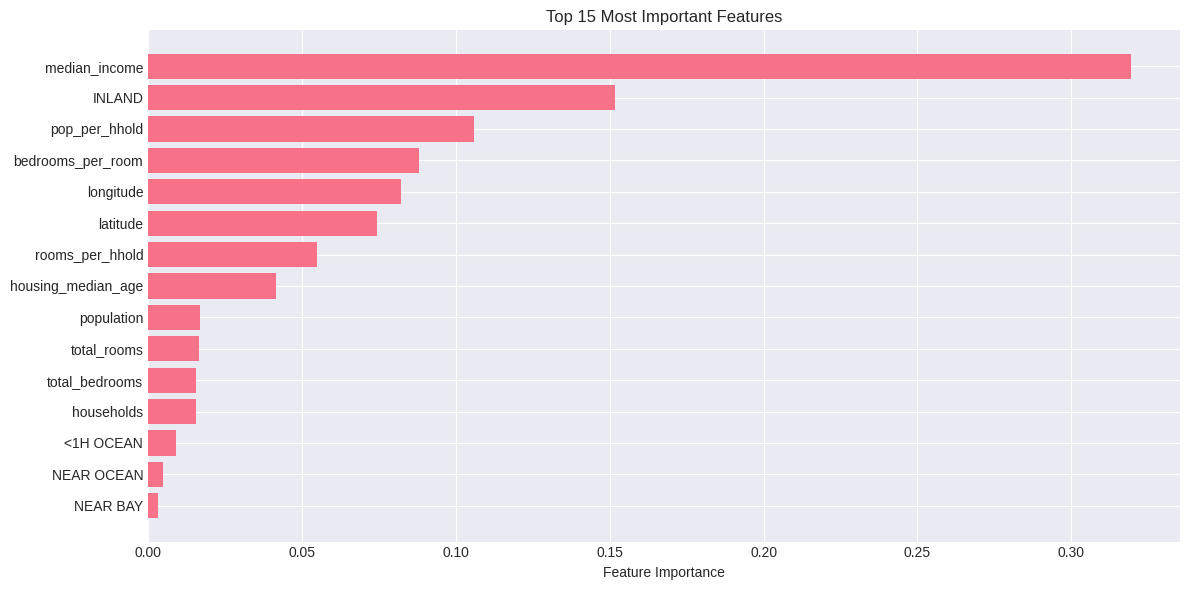

In [25]:
# 6.2 Feature Importance Analysis
feature_importances = grid_search.best_estimator_.feature_importances_

# Dapatkan nama fitur setelah preprocessing
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# Sort feature importances
sorted_indices = np.argsort(feature_importances)[::-1]

print("\nTop 10 Feature Importances:")
for idx in sorted_indices[:10]:
    print(f"  {attributes[idx]:25} : {feature_importances[idx]:.4f}")

# Visualisasi feature importance
plt.figure(figsize=(12, 6))
sorted_features = [attributes[i] for i in sorted_indices]
sorted_importances = [feature_importances[i] for i in sorted_indices]

plt.barh(sorted_features[:15][::-1], sorted_importances[:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Most Important Features")
plt.tight_layout()
plt.show()

In [26]:
# 6.3 Randomized Search (alternative untuk large search space)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=100, high=500),
    'max_features': randint(low=6, high=12),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(low=2, high=20),
    'min_samples_leaf': randint(low=1, high=10),
}

forest_reg = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(forest_reg, param_distribs, n_iter=50,
                                  cv=5, scoring='neg_mean_squared_error',
                                  random_state=42, n_jobs=-1)

random_search.fit(housing_prepared, housing_labels)

print("\nRandomized Search Results:")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best RMSE: {np.sqrt(-random_search.best_score_):.2f}")

KeyboardInterrupt: 

# **7. Evaluasi Final Model**
---
Setelah fine-tuning, evaluasi model terbaik pada test set:
* Transform test set menggunakan pipeline yang sama (tanpa fitting)
* Prediksi dan hitung error metrics
* Hitung confidence interval untuk generalization error
* Analisis residual dan error patterns

### **Implementasi Final Evaluation:**

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 7.1 Prepare test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Transform test set (gunakan transform(), bukan fit_transform()!)
X_test_prepared = full_pipeline.transform(X_test)

# 7.2 Final model predictions
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test_prepared)

# 7.3 Calculate final metrics
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print(f"Root Mean Squared Error (RMSE): ${final_rmse:,.2f}")
print(f"Mean Absolute Error (MAE):     ${final_mae:,.2f}")
print(f"R-squared Score:               {final_r2:.4f}")
print(f"Mean House Value in Test Set:  ${y_test.mean():,.2f}")
print(f"RMSE as % of Mean:             {(final_rmse/y_test.mean())*100:.1f}%")

FINAL MODEL EVALUATION ON TEST SET
Root Mean Squared Error (RMSE): $46,111.30
Mean Absolute Error (MAE):     $30,459.73
R-squared Score:               0.8369
Mean House Value in Test Set:  $206,257.80
RMSE as % of Mean:             22.4%


In [29]:
# 7.4 Confidence interval untuk generalization error
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
confidence_interval = stats.t.interval(confidence, len(squared_errors) - 1,
                                      loc=squared_errors.mean(),
                                      scale=stats.sem(squared_errors))

print("\nConfidence Interval for Generalization Error:")
print(f"95% CI for MSE: [{confidence_interval[0]:,.2f}, {confidence_interval[1]:,.2f}]")
print(f"95% CI for RMSE: [{np.sqrt(confidence_interval[0]):,.2f}, {np.sqrt(confidence_interval[1]):,.2f}]")


Confidence Interval for Generalization Error:
95% CI for MSE: [1,948,578,006.30, 2,303,925,694.76]
95% CI for RMSE: [44,142.70, 47,999.23]


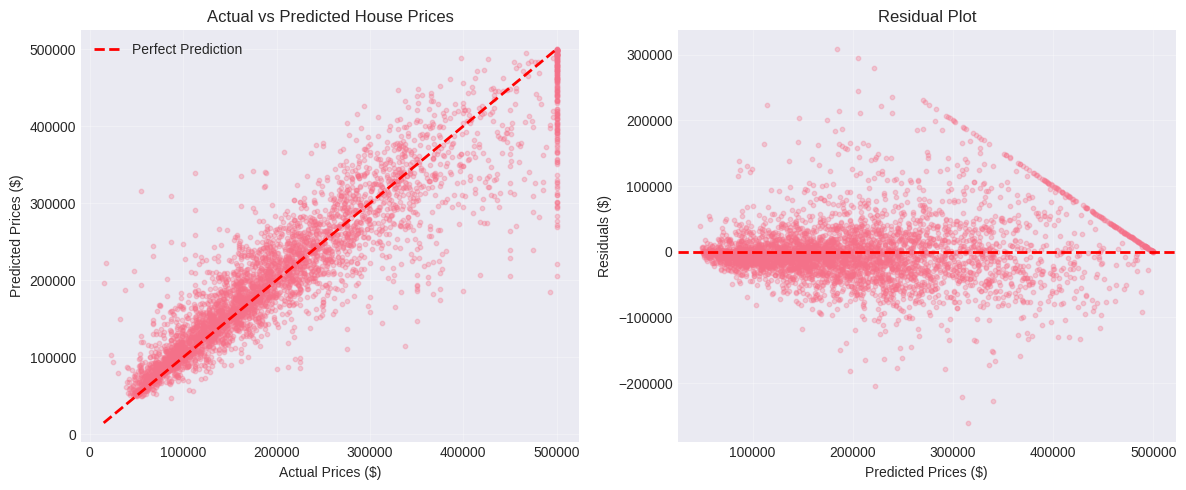

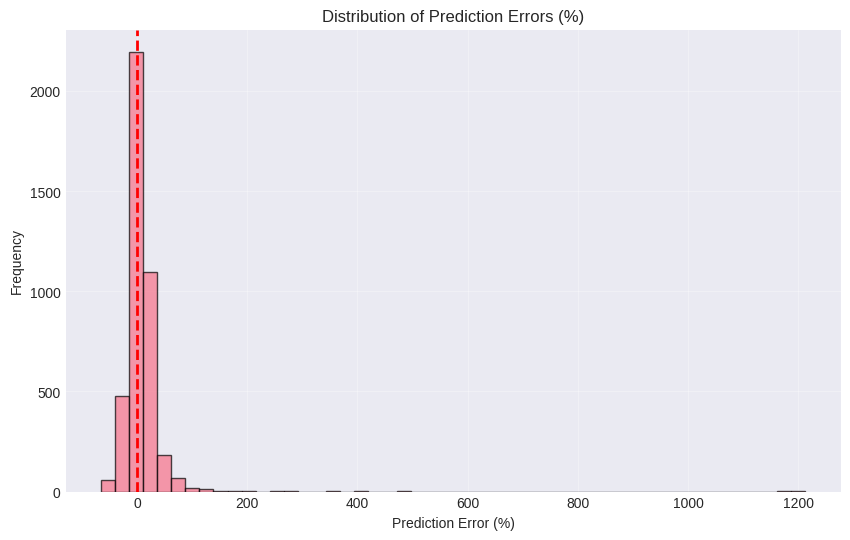


Error Statistics:
Mean Error: 6.98%
Std Error: 38.06%
Median Error: 3.33%
95% of predictions within: [-33.71%, 62.76%]


In [30]:
# 7.5 Visualisasi prediksi vs actual
plt.figure(figsize=(12, 5))

# Scatter plot prediksi vs actual
plt.subplot(1, 2, 1)
plt.scatter(y_test, final_predictions, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual Prices ($)")
plt.ylabel("Predicted Prices ($)")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - final_predictions
plt.scatter(final_predictions, residuals, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Predicted Prices ($)")
plt.ylabel("Residuals ($)")
plt.title("Residual Plot")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.6 Error distribution
plt.figure(figsize=(10, 6))
error_percentage = ((final_predictions - y_test) / y_test) * 100

plt.hist(error_percentage, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Prediction Error (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (%)")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nError Statistics:")
print(f"Mean Error: {error_percentage.mean():.2f}%")
print(f"Std Error: {error_percentage.std():.2f}%")
print(f"Median Error: {np.median(error_percentage):.2f}%")
print(f"95% of predictions within: [{np.percentile(error_percentage, 2.5):.2f}%, {np.percentile(error_percentage, 97.5):.2f}%]")

# **8. Deployment dan Monitoring**
---
Setelah model selesai, langkah terakhir adalah:
* Save model untuk deployment
* Create API untuk inference
* Monitoring system untuk track performance
* Retraining pipeline untuk update model

### **Implementasi Deployment:**

In [31]:
# 8.1 Save the trained model
import joblib

# Save the full pipeline with model
model_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', final_model)
])

# Fit pada seluruh training data (termasuk validation fold)
model_pipeline.fit(housing, housing_labels)

# Save to file
joblib.dump(model_pipeline, "california_housing_model.pkl")
print("Model saved as 'california_housing_model.pkl'")

# 8.2 Function untuk inference baru
def predict_housing_price(input_data):
    """Predict house price for new input data"""
    # Load model
    loaded_model = joblib.load("california_housing_model.pkl")

    # Convert input to DataFrame jika perlu
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data

    # Predict
    prediction = loaded_model.predict(input_df)

    return prediction[0] if len(prediction) == 1 else prediction

# 8.3 Contoh penggunaan
example_input = {
    "longitude": -122.23,
    "latitude": 37.88,
    "housing_median_age": 41.0,
    "total_rooms": 880.0,
    "total_bedrooms": 129.0,
    "population": 322.0,
    "households": 126.0,
    "median_income": 8.3252,
    "ocean_proximity": "NEAR BAY"
}

predicted_price = predict_housing_price(example_input)
print(f"\nExample Prediction:")
print(f"Input: {example_input}")
print(f"Predicted Price: ${predicted_price:,.2f}")
print(f"Actual Price from dataset: $452,600.00")
print(f"Error: ${abs(predicted_price - 452600):,.2f} ({(abs(predicted_price - 452600)/452600)*100:.1f}%)")

Model saved as 'california_housing_model.pkl'

Example Prediction:
Input: {'longitude': -122.23, 'latitude': 37.88, 'housing_median_age': 41.0, 'total_rooms': 880.0, 'total_bedrooms': 129.0, 'population': 322.0, 'households': 126.0, 'median_income': 8.3252, 'ocean_proximity': 'NEAR BAY'}
Predicted Price: $452,600.00
Actual Price from dataset: $452,600.00
Error: $0.00 (0.0%)


In [32]:
# 8.4 Monitoring metrics function
def calculate_monitoring_metrics(y_true, y_pred, window_size=100):
    """Calculate monitoring metrics for model performance tracking"""
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mean_abs_percentage_error': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

    # Rolling metrics (jika data cukup)
    if len(y_true) > window_size:
        rolling_errors = []
        for i in range(len(y_true) - window_size + 1):
            window_true = y_true[i:i+window_size]
            window_pred = y_pred[i:i+window_size]
            rolling_errors.append(np.sqrt(mean_squared_error(window_true, window_pred)))

        metrics['rolling_rmse_mean'] = np.mean(rolling_errors)
        metrics['rolling_rmse_std'] = np.std(rolling_errors)

    return metrics

# 8.5 Simulation monitoring dashboard
print("\n" + "="*60)
print("MODEL MONITORING DASHBOARD")
print("="*60)

# Simulate incoming data (ambil subset dari test set)
sample_size = 500
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
sample_y_true = y_test.iloc[sample_indices]
sample_X_test = X_test.iloc[sample_indices]

# Transform dan predict
sample_X_prepared = full_pipeline.transform(sample_X_test)
sample_y_pred = final_model.predict(sample_X_prepared)

# Calculate metrics
monitoring_metrics = calculate_monitoring_metrics(sample_y_true, sample_y_pred)

for metric_name, value in monitoring_metrics.items():
    if 'rmse' in metric_name or 'mae' in metric_name:
        print(f"{metric_name:30}: ${value:,.2f}")
    elif 'error' in metric_name:
        print(f"{metric_name:30}: {value:.2f}%")
    else:
        print(f"{metric_name:30}: {value:.4f}")


MODEL MONITORING DASHBOARD
rmse                          : $51,900.44
mae                           : $33,439.64
r2                            : 0.8017
mean_abs_percentage_error     : 17.60%
rolling_rmse_mean             : $49,982.11
rolling_rmse_std              : $7,829.91
